In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.optimized_search import OptimizedSearch
import evaluation_metrics

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle
import copy

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [47]:
input_shape = (28, 28, 1)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/fashion_keras/fashion_seq_large_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L Fashion/'
name = 'fashion_seq_large'

from test_models.fashion_keras import data
_, test_data = data.get_data()

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0.9247


In [80]:
layer_name = 'conv2d_5'
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
original_weights = model_obj.get_model_weights_by_layer()[4]

model_obj.model = fxp_quantize.quantize_weights(model_obj.model, 4, 3, layer_name=[layer_name])

quantized_weights = model_obj.get_model_weights_by_layer()[4]

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
original_weights = model_obj.get_model_weights_by_layer()[4][0]
quant_weights = []
test_cases = [(4, 3), (4, 5), (2, 5)]
for x in test_cases:
    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj.model = fxp_quantize.quantize_weights(model_obj.model, x[0], x[1], layer_name=[layer_name])
    quant_weights.append(model_obj.get_model_weights_by_layer()[4][0])

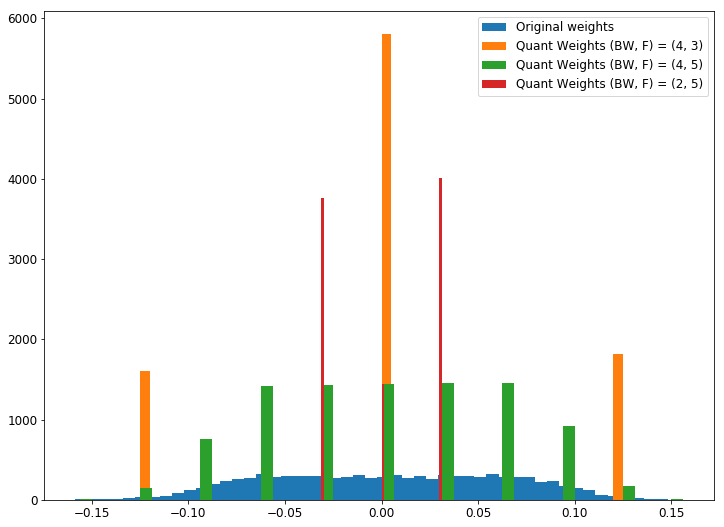

In [67]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.hist(original_weights.flatten(), bins=50, label='Original weights')
for i in range(len(quant_weights)):
    plt.hist(quant_weights[i].flatten(), bins=50, label=f'Quant Weights (BW, F) = ({test_cases[i][0]}, {test_cases[i][1]})')
plt.legend();
plt.savefig('C:/Users/320060820/Onedrive - Philips/Thesis docs/Images/quantizing_weights.png', bbox_inches='tight')

# plt.grid();

In [48]:
layer_name = 'conv2d_5'
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
original_activations = model_obj.get_activation_maps(model_obj.x_test[:50], layer_name)

quant_act = []
test_cases = [(3, 0), (4, 0), (4, -1)]
for x in test_cases:
    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model({layer_name:[x[0], x[1]]}))
    quant_act.append(model_obj.get_activation_maps(model_obj.x_test[:50], 'lambda_1'))

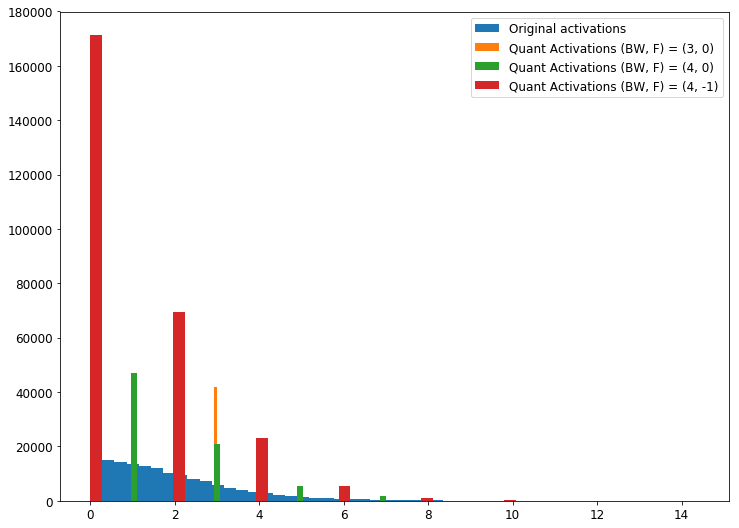

In [85]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.hist(original_activations.flatten(), bins=50, label='Original activations')
for i in range(len(quant_act)):
    plt.hist(quant_act[i].flatten(), bins=50, label=f'Quant Activations (BW, F) = ({test_cases[i][0]}, {test_cases[i][1]})')
plt.legend();
plt.savefig('C:/Users/320060820/Onedrive - Philips/Thesis docs/Images/quantizing_activations.png', bbox_inches='tight')

# plt.grid();

In [82]:
input_shape = (28, 28, 1)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_keras_w.h5'
name = 'mnist_keras'

from test_models.mnist_custom import data
_, test_data = data.get_data()

model_obj = keras_cnn.KerasCNN(input_shape, num_outputs, path_trained_weights)

In [95]:
layer_name = 'conv2d_2'
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
original_weights = model_obj.get_model_weights_by_layer()[1]

model_obj.model = fxp_quantize.quantize_weights(model_obj.model, 4, 3, layer_name=[layer_name])

quantized_weights = model_obj.get_model_weights_by_layer()[1]

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
original_weights = model_obj.get_model_weights_by_layer()[1][0]
quant_weights = []
test_cases = [(4, 4), (4, 3), (4, 2)]
for x in test_cases:
    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj.model = fxp_quantize.quantize_weights(model_obj.model, x[0], x[1], layer_name=[layer_name])
    quant_weights.append(model_obj.get_model_weights_by_layer()[1][0])

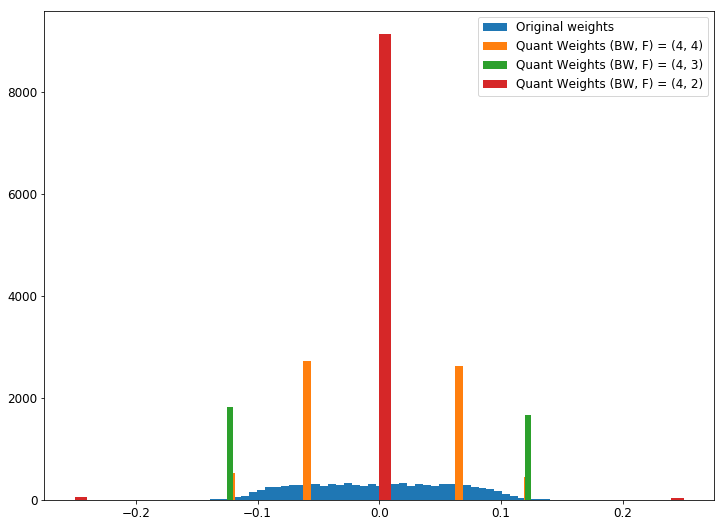

In [96]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.hist(original_weights.flatten(), bins=50, label='Original weights')
for i in range(len(quant_weights)):
    plt.hist(quant_weights[i].flatten(), bins=50, label=f'Quant Weights (BW, F) = ({test_cases[i][0]}, {test_cases[i][1]})')
plt.legend();
plt.savefig('C:/Users/320060820/Onedrive - Philips/Thesis docs/Images/rounding_weights.png', bbox_inches='tight')

# plt.grid();

In [97]:
layer_name = 'conv2d_2'
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
original_weights = model_obj.get_model_weights_by_layer()[1]

model_obj.model = fxp_quantize.quantize_weights(model_obj.model, 4, 3, layer_name=[layer_name])

quantized_weights = model_obj.get_model_weights_by_layer()[1]

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
original_weights = model_obj.get_model_weights_by_layer()[1][0]
quant_weights = []
test_cases = [(4, 5), (2, 5), (4, 7)]
for x in test_cases:
    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj.model = fxp_quantize.quantize_weights(model_obj.model, x[0], x[1], layer_name=[layer_name])
    quant_weights.append(model_obj.get_model_weights_by_layer()[1][0])

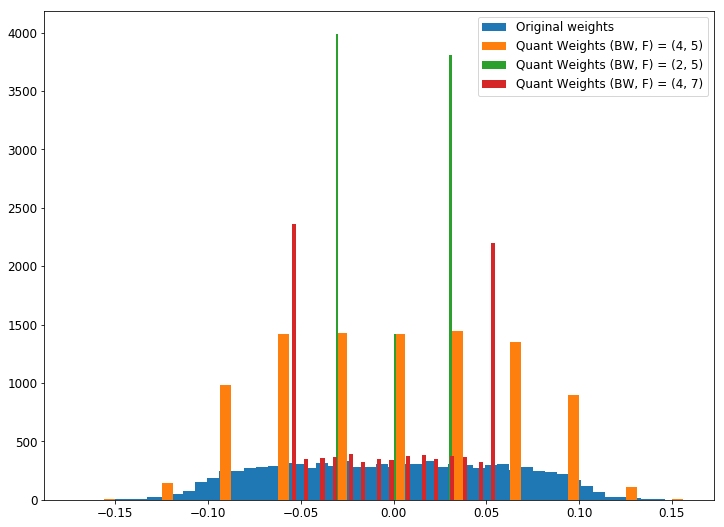

In [98]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.hist(original_weights.flatten(), bins=50, label='Original weights')
for i in range(len(quant_weights)):
    plt.hist(quant_weights[i].flatten(), bins=50, label=f'Quant Weights (BW, F) = ({test_cases[i][0]}, {test_cases[i][1]})')
plt.legend();
plt.savefig('C:/Users/320060820/Onedrive - Philips/Thesis docs/Images/clipping_weights.png', bbox_inches='tight')

# plt.grid();

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

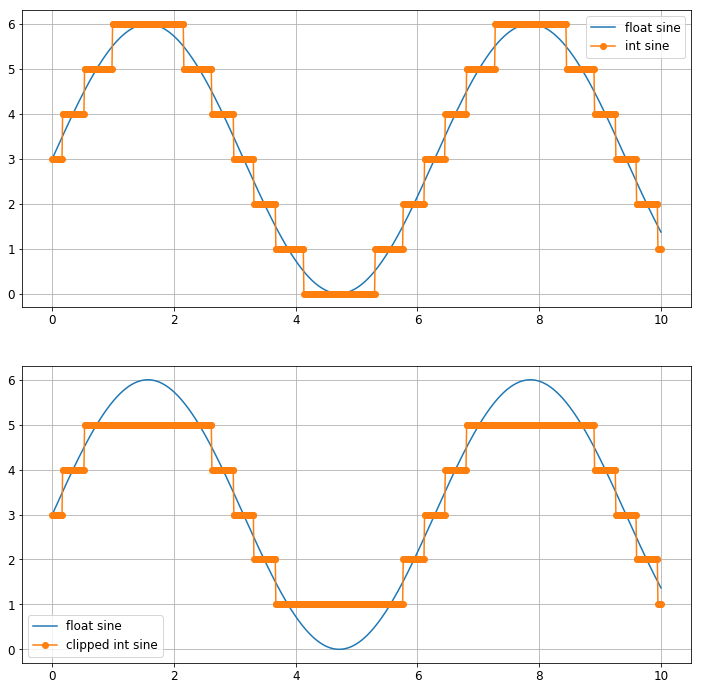

In [9]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
x = np.linspace(0, 10, 1000)
y1 = 3 * (np.sin(x) + 1)
y2 = np.around(y1)
y3 = np.clip(y2, 1, 5)
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(x, y1, label='float sine')
plt.plot(x, y2, 'o-', label='int sine')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot(x, y1, label='float sine')
plt.plot(x, y3, 'o-', label='clipped int sine')
plt.grid()
plt.legend()
plt.savefig('C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/quantization_sine2.png', bbox_inches='tight')

In [1]:
f = lambda x: 2**x

In [11]:
f(0) + f(3) + f(4) + f(6) + f(-2) + f(-3) + f(-5)

89.40625

In [4]:
f(1) + f(2) + f(4) + f(7) + f(8)

406

In [6]:
-7 / 2**4

-0.4375

In [3]:
import scipy

In [4]:
im = scipy.ndimage.imread('C:/Users/320060820/OneDrive - Philips/Thesis docs/Images/che-guevara.jpg', flatten=True)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


In [43]:
from convert_float_fixed import ConvertFloatFixed
cff1 = ConvertFloatFixed(9, 0)
cff2 = ConvertFloatFixed(6, -3)
cff3 = ConvertFloatFixed(3, -6)
cff4 = ConvertFloatFixed(2, -7)

In [6]:
p = lambda x: plt.imshow(x, cmap='gray', vmin=0, vmax=255)

In [23]:
im2.max()

256.0

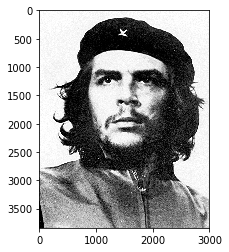

In [7]:
plt.imshow(im, cmap='gray', vmin=0, vmax=255)

In [38]:
im1 = cff1.quantize(im)
im2 = cff2.quantize(im)
im3 = cff3.quantize(im)
im4 = cff4.quantize(im)

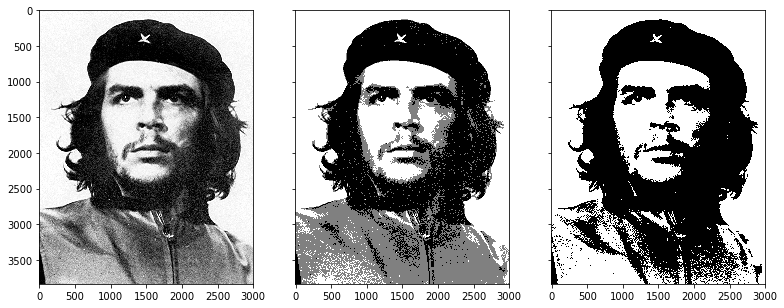

In [79]:
fig, axes = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
ax = axes.flat
ax[0].imshow(im1, cmap='gray', vmin=0, vmax=255)
ax[1].imshow(im3, cmap='gray', vmin=0, vmax=255)
ax[2].imshow(im4, cmap='gray', vmin=0, vmax=255)
fig.savefig('C:/Users/320060820/OneDrive - Philips/Thesis docs/Images/che-guevara-quant.png', bbox_inches='tight')